In [1]:
from neuralprophet import NeuralProphet, set_random_seed, load
from model_xgb import ModelXGB
from model_np import ModelNP
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_percentage_error as mape, mean_squared_error as mse

Evaluation models' performance using PJM metered loads in Oct. 2022.

## NeuralProphet

In [2]:
hrl = pd.read_csv('Data/hrl_load_metered_oct.csv')
hrl['ds'] = pd.to_datetime(hrl['datetime_beginning_ept'])
hrl = hrl.groupby(['ds', 'zone']).agg({'mw': 'sum'}).reset_index()
zmap = pd.read_csv('Data/zone_mapping_hist_peak.csv')
hrl = hrl[hrl['zone'].isin(zmap['zone'])]
hrl.tail()

,ds,zone,mw
20058,2022-10-31 23:00:00,PEP,2443.662
20059,2022-10-31 23:00:00,PL,3739.562
20060,2022-10-31 23:00:00,PN,1635.920
20061,2022-10-31 23:00:00,PS,4088.193
20062,2022-10-31 23:00:00,RECO,123.348


In [ ]:
zone = 'AEP'
hrl1 = hrl[hrl['zone'] == zone]

m1 = ModelNP(zone)
pred1 = []
for i in range(31):
    idx1 = 24*i
    idx2 = idx1 + 24*7
    p1 = m1.predict(hrl1.iloc[idx1:idx2])
    p1 = p1[p1['source'] == 'pred']
    pred1.append(p1)
pred1 = pd.concat(pred1, axis=0)

<AxesSubplot: title={'center': 'MAPE: 0.0245, RMSE: 413.6876'}, xlabel='ds'>

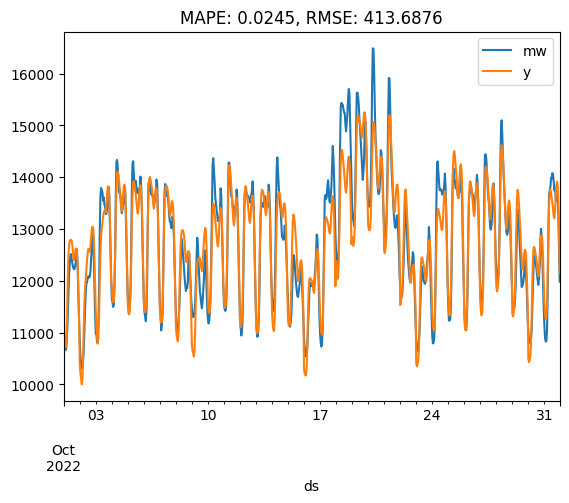

In [4]:
pred_m1 = pred1.merge(hrl1, on='ds')
e1 = mape(pred_m1['y'], pred_m1['mw'])
e2 = mse(pred_m1['y'], pred_m1['mw'], squared=False)
pred_m1.plot(x='ds', y=['mw', 'y'], title="MAPE: {}, RMSE: {}".format(round(e1, 4), round(e2, 4)))

In [ ]:
err1 = []
for zone in zmap.zone.unique():
    hrl1 = hrl[hrl['zone'] == zone]

    m1 = ModelNP(zone)
    pred1 = []
    for i in range(31):
        idx1 = 24*i
        idx2 = idx1 + 24*7
        p1 = m1.predict(hrl1.iloc[idx1:idx2])
        p1 = p1[p1['source'] == 'pred']
        pred1.append(p1)
    pred1 = pd.concat(pred1, axis=0)
    pred_m1 = pred1.merge(hrl1, on='ds')
    e1 = mape(pred_m1['y'], pred_m1['mw'])
    e2 = mse(pred_m1['y'], pred_m1['mw'], squared=False)
    err1.append([e1, e2])
    #print(zone)

In [12]:
err1 = pd.DataFrame(err1)
err1['zone'] = zmap.zone.unique()
err1

,0,1,zone
0,0.059553,74.031885,AE
1,0.024483,413.687595,AEP
2,0.031782,193.788322,AP
3,0.038021,163.710457,BC
4,0.038254,454.803403,CE
5,0.030780,66.119921,DAY
6,0.031851,99.001557,DEOK
7,0.047443,817.870255,DOM
8,0.040899,87.923957,DPL
9,0.026101,42.465774,DUQ


## XGBoost

In [5]:
m2 = ModelXGB(zone)

start_date = datetime(2022, 10, 1)
pred2 = []
for dt in range(31):
    p2 = m2.predict(start_date.strftime('%Y-%m-%d'))
    pred2.append(p2)
    start_date = start_date + timedelta(1)

pred2 = pd.concat(pred2, axis=0)

<AxesSubplot: title={'center': 'MAPE: 0.0411, RMSE: 1155.4914'}, xlabel='ds'>

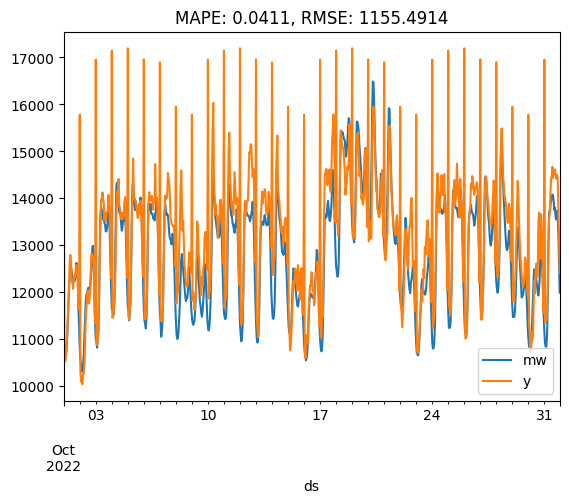

In [6]:
hrl1 = hrl[hrl['zone'] == zone]
pred2['ds'] = pd.to_datetime(pred2['date']) + pred2['hour'].astype('timedelta64[h]')
pred_m2 = pred2.merge(hrl1, on='ds')
pred_m2 = pred_m2.rename(columns={'mw_x': 'y', 'mw_y': 'mw'})
e1 = mape(pred_m2['y'], pred_m2['mw'])
e2 = mse(pred_m2['y'], pred_m2['mw'], squared=False)
pred_m2.plot(x='ds', y=['mw', 'y'], title="MAPE: {}, RMSE: {}".format(round(e1, 4), round(e2, 4)))

In [7]:
err2 = []
for zone in zmap.zone.unique():
    m2 = ModelXGB(zone)

    start_date = datetime(2022, 10, 1)
    pred2 = []
    for dt in range(31):
        p2 = m2.predict(start_date.strftime('%Y-%m-%d'))
        pred2.append(p2)
        start_date = start_date + timedelta(1)

    pred2 = pd.concat(pred2, axis=0)

    hrl1 = hrl[hrl['zone'] == zone]
    pred2['ds'] = pd.to_datetime(pred2['date']) + pred2['hour'].astype('timedelta64[h]')
    pred_m2 = pred2.merge(hrl1, on='ds')
    pred_m2 = pred_m2.rename(columns={'mw_x': 'y', 'mw_y': 'mw'})
    e1 = mape(pred_m2['y'], pred_m2['mw'])
    e2 = mse(pred_m2['y'], pred_m2['mw'], squared=False)
    err2.append([e1, e2])

err2 = pd.DataFrame(err2)

In [8]:
err2['zone'] = zmap.zone.unique()

,MAPE_np,RMSE_np,MAPE_xgb,RMSE_xgb
zone,,,,
AE,0.059553,74.031885,0.071256,93.199624
AEP,0.024483,413.687595,0.041132,1155.491446
AP,0.031782,193.788322,0.046769,393.343575
BC,0.038021,163.710457,0.047165,309.494379
CE,0.038254,454.803403,0.044117,657.693464
DAY,0.030780,66.119921,0.048229,131.814309
DEOK,0.031851,99.001557,0.051987,246.989951
DOM,0.047443,817.870255,0.047144,1117.727707
DPL,0.040899,87.923957,0.057562,302.923131


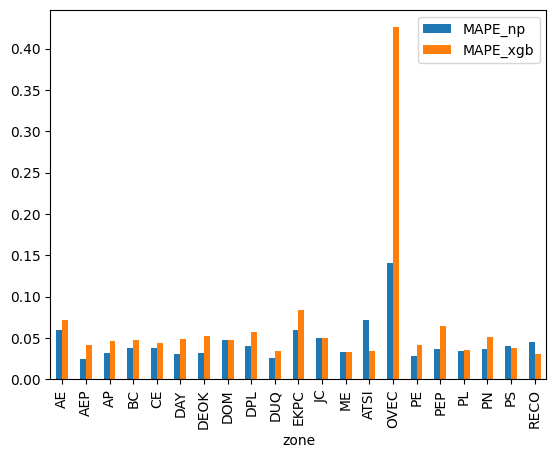

In [13]:
Err = err1.merge(err2, on='zone')
Err.columns = ['MAPE_np', 'RMSE_np', 'zone', 'MAPE_xgb', 'RMSE_xgb']
Err = Err.set_index('zone')
Err[['MAPE_np', 'MAPE_xgb']].plot.bar()
Err